# Setup
In this notebook, we will generate some synthetic data to demonstrate how sensitivity analysis work by different methods.

# Sensitivity Analysis
## Methods
We provided five methods for sensitivity analysis including (Placebb Treatment, Random Cause, Subset Data, Random Replace and Selection Bias). 
This notebook will walkthrough how to use the combined function sensitivity_analysis() to compare different method and also how to use each individual method separately:

1. Placebo Treatment: Replacing treatment with a random variable
2. Irrelevant Additional Confounder: Adding a random common cause variable
3. Subset validation: Removing a random subset of the data
4. Selection Bias method with One Sided confounding function and Alignment confounding function
5. Random Replace: Random replace a covariate with an irrelevant variable

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
import matplotlib
from causalml.inference.meta import BaseXLearner
from causalml.dataset import synthetic_data

from causalml.metrics.sensitivity import Sensitivity
from causalml.metrics.sensitivity import SensitivityRandomReplace, SensitivitySelectionBias

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = [8, 8]
warnings.filterwarnings('ignore')

# logging.basicConfig(level=logging.INFO)

pd.options.display.float_format = '{:.4f}'.format

/Users/jing.pan/anaconda3/envs/causalml_3_6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Pred

## Generate Synthetic data

In [4]:
# Generate synthetic data using mode 1
num_features = 6 
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=100000, p=num_features, sigma=1.0)

In [5]:
tau.mean()

0.5001096146567363

## Define Features

In [6]:
# Generate features names
INFERENCE_FEATURES = ['feature_' + str(i) for i in range(num_features)]
TREATMENT_COL = 'target'
OUTCOME_COL = 'outcome'
SCORE_COL = 'pihat'

In [7]:
df = pd.DataFrame(X, columns=INFERENCE_FEATURES)
df[TREATMENT_COL] = treatment
df[OUTCOME_COL] = y
df[SCORE_COL] = e

In [8]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,target,outcome,pihat
0,0.9536,0.2911,0.0432,0.8720,0.5190,0.0822,1,2.0220,0.7657
1,0.2390,0.3096,0.5115,0.2048,0.8914,0.5015,0,-0.0732,0.2304
2,0.1091,0.0765,0.7428,0.6951,0.4580,0.7800,0,-1.4947,0.1000
3,0.2055,0.3967,0.6278,0.2086,0.3865,0.8860,0,0.6458,0.2533
4,0.4501,0.0578,0.3972,0.4100,0.5760,0.4764,0,-0.0018,0.1000


# Sensitivity Analysis

## With all Covariates

### Sensitivity Analysis Summary Report (with One-sided confounding function and default alpha)

In [9]:
# Calling the Base XLearner class and return the sensitivity analysis summary report
learner_x = BaseXLearner(LinearRegression())
sens_x = Sensitivity(df=df, inference_features=INFERENCE_FEATURES, p_col='pihat',
                     treatment_col=TREATMENT_COL, outcome_col=OUTCOME_COL, learner=learner_x)
# Here for Selection Bias method will use default one-sided confounding function and alpha (quantile range of outcome values) input
sens_sumary_x = sens_x.sensitivity_analysis(methods=['Placebo Treatment',
                                                     'Random Cause',
                                                     'Subset Data',
                                                     'Random Replace',
                                                     'Selection Bias'], sample_size=0.5)

In [10]:
# From the following results, refutation methods show our model is pretty robust; 
# When alpah > 0, the treated group always has higher mean potential outcomes than the control; when  < 0, the control group is better off.
sens_sumary_x

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Placebo Treatment,0.6801,-0.0025,-0.0158,0.0107
0,Random Cause,0.6801,0.6801,0.6673,0.6929
0,Subset Data(sample size @0.5),0.6801,0.6874,0.6693,0.7055
0,Random Replace,0.6801,0.6799,0.6670,0.6929
0,"Selection Bias (alpha@-0.80111, with r-sqaure:...",0.6801,1.3473,1.3347,1.3599
0,"Selection Bias (alpha@-0.64088, with r-sqaure:...",0.6801,1.2139,1.2013,1.2265
0,"Selection Bias (alpha@-0.48066, with r-sqaure:...",0.6801,1.0804,1.0678,1.0931
0,"Selection Bias (alpha@-0.32044, with r-sqaure:...",0.6801,0.9470,0.9343,0.9597
0,"Selection Bias (alpha@-0.16022, with r-sqaure:...",0.6801,0.8135,0.8008,0.8263
0,"Selection Bias (alpha@0.0, with r-sqaure:0.0",0.6801,0.6801,0.6673,0.6929


### Random Replace

In [11]:
# Replace feature_0 with an irrelevent variable
sens_x_replace = SensitivityRandomReplace(df=df, inference_features=INFERENCE_FEATURES, p_col='pihat',
                                          treatment_col=TREATMENT_COL, outcome_col=OUTCOME_COL, learner=learner_x,
                                          sample_size=0.9, replaced_feature='feature_0')
s_check_replace = sens_x_replace.summary(method='Random Replace')
s_check_replace

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Random Replace,0.6801,0.8072,0.7943,0.8200


### Selection Bias: Alignment confounding Function

In [12]:
sens_x_bias_alignment = SensitivitySelectionBias(df, INFERENCE_FEATURES, p_col='pihat', treatment_col=TREATMENT_COL,
                                                 outcome_col=OUTCOME_COL, learner=learner_x, confound='alignment',
                                                 alpha_range=None)

In [13]:
lls_x_bias_alignment, partial_rsqs_x_bias_alignment = sens_x_bias_alignment.causalsens()

In [14]:
lls_x_bias_alignment

,alpha,rsqs,New ATE,New ATE LB,New ATE UB
0,-0.8011,0.1088,0.6685,0.6556,0.6813
0,-0.6409,0.0728,0.6708,0.6580,0.6836
0,-0.4807,0.0425,0.6731,0.6604,0.6859
0,-0.3204,0.0194,0.6754,0.6627,0.6882
0,-0.1602,0.0050,0.6778,0.6650,0.6905
0,0.0000,0.0000,0.6801,0.6673,0.6929
0,0.1602,0.0050,0.6824,0.6696,0.6953
0,0.3204,0.0200,0.6848,0.6718,0.6977
0,0.4807,0.0443,0.6871,0.6741,0.7001
0,0.6409,0.0769,0.6894,0.6763,0.7026


In [15]:
partial_rsqs_x_bias_alignment

,feature,partial_rsqs
0,feature_0,-0.0631
1,feature_1,-0.0619
2,feature_2,-0.0001
3,feature_3,-0.0033
4,feature_4,-0.0001
5,feature_5,0.0000


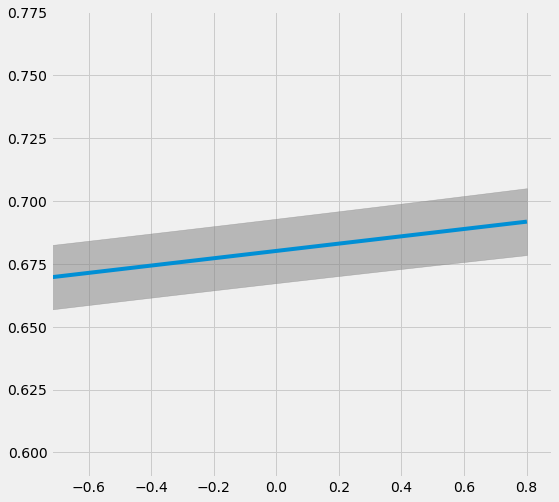

In [16]:
# Plot the results by confounding vector and plot Confidence Intervals for ATE
sens_x_bias_alignment.plot(lls_x_bias_alignment, ci=True)

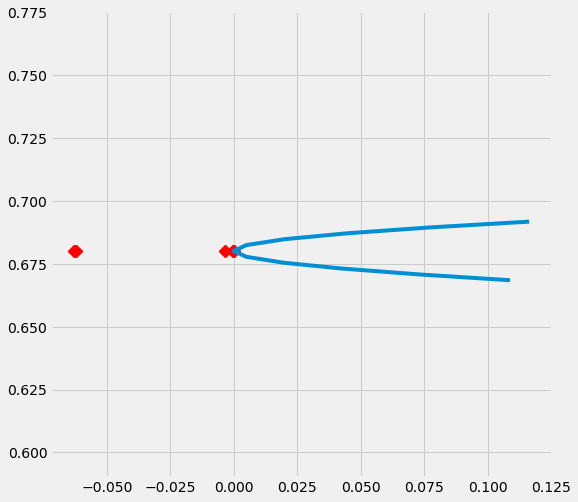

In [17]:
# Plot the results by rsquare with partial r-square results by each individual features
sens_x_bias_alignment.plot(lls_x_bias_alignment, partial_rsqs_x_bias_alignment, type='r.squared', partial_rsqs=True)

## Drop One Confounder

In [18]:
df_new = df.drop('feature_0', axis=1).copy()
INFERENCE_FEATURES_new = INFERENCE_FEATURES.copy()
INFERENCE_FEATURES_new.remove('feature_0')
df_new.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target,outcome,pihat
0,0.2911,0.0432,0.8720,0.5190,0.0822,1,2.0220,0.7657
1,0.3096,0.5115,0.2048,0.8914,0.5015,0,-0.0732,0.2304
2,0.0765,0.7428,0.6951,0.4580,0.7800,0,-1.4947,0.1000
3,0.3967,0.6278,0.2086,0.3865,0.8860,0,0.6458,0.2533
4,0.0578,0.3972,0.4100,0.5760,0.4764,0,-0.0018,0.1000


In [19]:
INFERENCE_FEATURES_new

['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

### Sensitivity Analysis Summary Report (with One-sided confounding function and default alpha)

In [20]:
sens_x_new = Sensitivity(df=df_new, inference_features=INFERENCE_FEATURES_new, p_col='pihat',
                     treatment_col=TREATMENT_COL, outcome_col=OUTCOME_COL, learner=learner_x)
# Here for Selection Bias method will use default one-sided confounding function and alpha (quantile range of outcome values) input
sens_sumary_x_new = sens_x_new.sensitivity_analysis(methods=['Placebo Treatment',
                                                     'Random Cause',
                                                     'Subset Data',
                                                     'Random Replace',
                                                     'Selection Bias'], sample_size=0.5)

In [21]:
# Here we can see the New ATE restul from Random Replace method actually changed ~ 12.5%
sens_sumary_x_new

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Placebo Treatment,0.8072,0.0104,-0.0033,0.0242
0,Random Cause,0.8072,0.8072,0.7943,0.8201
0,Subset Data(sample size @0.5),0.8072,0.8180,0.7998,0.8361
0,Random Replace,0.8072,0.8068,0.7938,0.8198
0,"Selection Bias (alpha@-0.80111, with r-sqaure:...",0.8072,1.3799,1.3673,1.3925
0,"Selection Bias (alpha@-0.64088, with r-sqaure:...",0.8072,1.2654,1.2527,1.2780
0,"Selection Bias (alpha@-0.48066, with r-sqaure:...",0.8072,1.1508,1.1381,1.1635
0,"Selection Bias (alpha@-0.32044, with r-sqaure:...",0.8072,1.0363,1.0235,1.0490
0,"Selection Bias (alpha@-0.16022, with r-sqaure:...",0.8072,0.9217,0.9089,0.9345
0,"Selection Bias (alpha@0.0, with r-sqaure:0.0",0.8072,0.8072,0.7943,0.8200


### Random Replace

In [22]:
# Replace feature_0 with an irrelevent variable
sens_x_replace_new = SensitivityRandomReplace(df=df_new, inference_features=INFERENCE_FEATURES_new, p_col='pihat',
                                          treatment_col=TREATMENT_COL, outcome_col=OUTCOME_COL, learner=learner_x,
                                          sample_size=0.9, replaced_feature='feature_1')
s_check_replace_new = sens_x_replace_new.summary(method='Random Replace')
s_check_replace_new

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Random Replace,0.8072,0.9022,0.8893,0.9152


### Selection Bias: Alignment confounding Function

In [23]:
sens_x_bias_alignment_new = SensitivitySelectionBias(df_new, INFERENCE_FEATURES_new, p_col='pihat', treatment_col=TREATMENT_COL,
                                                 outcome_col=OUTCOME_COL, learner=learner_x, confound='alignment',
                                                 alpha_range=None)

In [24]:
lls_x_bias_alignment_new, partial_rsqs_x_bias_alignment_new = sens_x_bias_alignment_new.causalsens()

In [25]:
lls_x_bias_alignment_new

,alpha,rsqs,New ATE,New ATE LB,New ATE UB
0,-0.8011,0.1121,0.7919,0.7789,0.8049
0,-0.6409,0.0732,0.7950,0.7820,0.8079
0,-0.4807,0.0419,0.7980,0.7851,0.8109
0,-0.3204,0.0188,0.8011,0.7882,0.8139
0,-0.1602,0.0047,0.8041,0.7912,0.8170
0,0.0000,0.0000,0.8072,0.7943,0.8200
0,0.1602,0.0048,0.8102,0.7973,0.8231
0,0.3204,0.0189,0.8133,0.8003,0.8262
0,0.4807,0.0420,0.8163,0.8032,0.8294
0,0.6409,0.0736,0.8194,0.8062,0.8325


In [26]:
partial_rsqs_x_bias_alignment_new

,feature,partial_rsqs
0,feature_1,-0.0345
1,feature_2,-0.0001
2,feature_3,-0.0038
3,feature_4,-0.0001
4,feature_5,0.0000


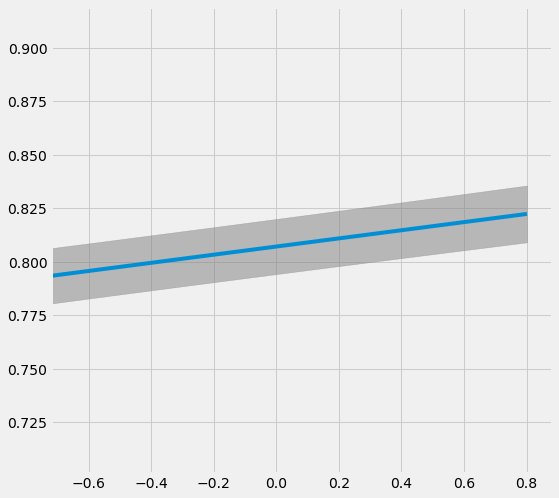

In [27]:
# Plot the results by confounding vector and plot Confidence Intervals for ATE
sens_x_bias_alignment_new.plot(lls_x_bias_alignment_new, ci=True)

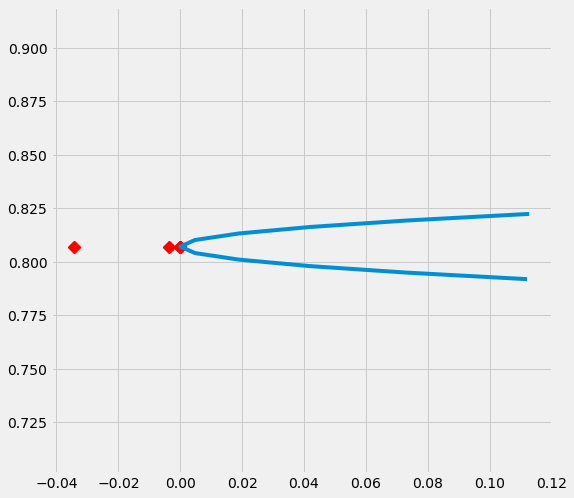

In [28]:
# Plot the results by rsquare with partial r-square results by each individual features
sens_x_bias_alignment_new.plot(lls_x_bias_alignment_new, partial_rsqs_x_bias_alignment_new, type='r.squared', partial_rsqs=True)

## Generate a Selection Bias Set

In [29]:
df_new_2 = df.copy()
df_new_2['treated_new'] = df['feature_0'].rank()
df_new_2['treated_new'] = [1 if i > df_new_2.shape[0]/2 else 0 for i in df_new_2['treated_new']]

In [30]:
df_new_2.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,target,outcome,pihat,treated_new
0,0.9536,0.2911,0.0432,0.8720,0.5190,0.0822,1,2.0220,0.7657,1
1,0.2390,0.3096,0.5115,0.2048,0.8914,0.5015,0,-0.0732,0.2304,0
2,0.1091,0.0765,0.7428,0.6951,0.4580,0.7800,0,-1.4947,0.1000,0
3,0.2055,0.3967,0.6278,0.2086,0.3865,0.8860,0,0.6458,0.2533,0
4,0.4501,0.0578,0.3972,0.4100,0.5760,0.4764,0,-0.0018,0.1000,0


### Sensitivity Analysis Summary Report (with One-sided confounding function and default alpha)

In [31]:
sens_x_new_2 = Sensitivity(df=df_new_2, inference_features=INFERENCE_FEATURES, p_col='pihat',
                     treatment_col='treated_new', outcome_col=OUTCOME_COL, learner=learner_x)
# Here for Selection Bias method will use default one-sided confounding function and alpha (quantile range of outcome values) input
sens_sumary_x_new_2 = sens_x_new_2.sensitivity_analysis(methods=['Placebo Treatment',
                                                     'Random Cause',
                                                     'Subset Data',
                                                     'Random Replace',
                                                     'Selection Bias'], sample_size=0.5)

In [32]:
sens_sumary_x_new_2

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Placebo Treatment,0.0432,0.0081,-0.0052,0.0213
0,Random Cause,0.0432,0.0432,0.0296,0.0568
0,Subset Data(sample size @0.5),0.0432,0.0976,0.0784,0.1167
0,Random Replace,0.0432,0.0433,0.0297,0.0568
0,"Selection Bias (alpha@-0.80111, with r-sqaure:...",0.0432,0.8369,0.8239,0.8499
0,"Selection Bias (alpha@-0.64088, with r-sqaure:...",0.0432,0.6782,0.6651,0.6913
0,"Selection Bias (alpha@-0.48066, with r-sqaure:...",0.0432,0.5194,0.5063,0.5326
0,"Selection Bias (alpha@-0.32044, with r-sqaure:...",0.0432,0.3607,0.3474,0.3740
0,"Selection Bias (alpha@-0.16022, with r-sqaure:...",0.0432,0.2020,0.1885,0.2154
0,"Selection Bias (alpha@0.0, with r-sqaure:0.0",0.0432,0.0432,0.0296,0.0568


### Random Replace

In [33]:
# Replace feature_0 with an irrelevent variable
sens_x_replace_new_2 = SensitivityRandomReplace(df=df_new_2, inference_features=INFERENCE_FEATURES, p_col='pihat',
                                          treatment_col='treated_new', outcome_col=OUTCOME_COL, learner=learner_x,
                                          sample_size=0.9, replaced_feature='feature_0')
s_check_replace_new_2 = sens_x_replace_new_2.summary(method='Random Replace')
s_check_replace_new_2

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Random Replace,0.0432,0.4847,0.4713,0.4981


### Selection Bias: Alignment confounding Function

In [34]:
sens_x_bias_alignment_new_2 = SensitivitySelectionBias(df_new_2, INFERENCE_FEATURES, p_col='pihat', treatment_col='treated_new',
                                                 outcome_col=OUTCOME_COL, learner=learner_x, confound='alignment',
                                                 alpha_range=None)

In [35]:
lls_x_bias_alignment_new_2, partial_rsqs_x_bias_alignment_new_2 = sens_x_bias_alignment_new_2.causalsens()

In [36]:
lls_x_bias_alignment_new_2

,alpha,rsqs,New ATE,New ATE LB,New ATE UB
0,-0.8011,0.0604,-0.2260,-0.2399,-0.2120
0,-0.6409,0.0415,-0.1721,-0.1860,-0.1583
0,-0.4807,0.0250,-0.1183,-0.1320,-0.1045
0,-0.3204,0.0119,-0.0645,-0.0781,-0.0508
0,-0.1602,0.0032,-0.0106,-0.0242,0.0030
0,0.0000,0.0000,0.0432,0.0296,0.0568
0,0.1602,0.0035,0.0971,0.0835,0.1106
0,0.3204,0.0148,0.1509,0.1373,0.1645
0,0.4807,0.0347,0.2047,0.1911,0.2183
0,0.6409,0.0635,0.2586,0.2449,0.2722


In [37]:
partial_rsqs_x_bias_alignment_new_2

,feature,partial_rsqs
0,feature_0,-0.4041
1,feature_1,0.0101
2,feature_2,0.0000
3,feature_3,0.0016
4,feature_4,0.0011
5,feature_5,0.0000


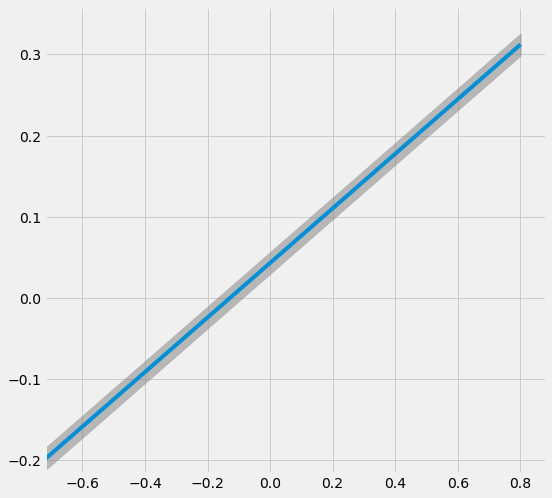

In [38]:
# Plot the results by confounding vector and plot Confidence Intervals for ATE
sens_x_bias_alignment_new_2.plot(lls_x_bias_alignment_new_2, ci=True)

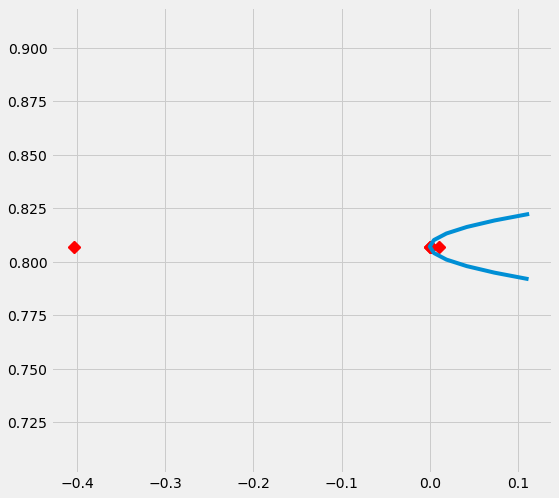

In [39]:
# Plot the results by rsquare with partial r-square results by each individual features
sens_x_bias_alignment_new_2.plot(lls_x_bias_alignment_new, partial_rsqs_x_bias_alignment_new_2, type='r.squared', partial_rsqs=True)